#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import bvcopula
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

animal = 'ST263'
dayN = 4
day_name = 'Day{}'.format(dayN)
path = '/home/nina/VRData/Processing/pkls'

with open("{}/{}_{}_signals.pkl".format(path,animal,day_name),'rb') as f:
    signal_pkl = pkl.load(f)
with open("{}/{}_{}_behaviour.pkl".format(path,animal,day_name),'rb') as f:
    behaviour_pkl = pkl.load(f)
for s in ['ROIsN','trialStart','maxTrialNum','trials']:
    assert(np.allclose(signal_pkl[s],behaviour_pkl[s]))

In [3]:
# import scipy.io

# path = "/home/nina/VRData/Processing/%s/%s-AllVR%i.mat" % (animal,animal,dayN)
# f = scipy.io.loadmat(path)
# inputs = {}
# for k,v in f.items():
#     inputs[k] = v
#     #print(k)
    
# maxTrialNum = np.shape(inputs['VRdata']['pertrial'][0,0]['new_pos'])[1]-1

# #find durations of each trial & the total duration
# trialLengths = []
# for trial_num in range(maxTrialNum):
#     trialLengths.append(np.shape(inputs['VRdata']['pertrial'][0,0]['new_pos'][0,trial_num])[0])
# maxL = np.sum(trialLengths)

# #find beginnings and ends of trials
# ends = np.cumsum(trialLengths)
# starts = np.concatenate((np.array([0]),np.cumsum(trialLengths)[:-1]))

# #bad trials
# trialStart = 0
# shiftStart = starts[trialStart]

# #adjust lengths of the arrays after throwing away first 'bad' trials
# maxL -= shiftStart
# starts -= shiftStart
# ends -= shiftStart

# #create empty arrays for handling recordings
# licks = np.zeros(maxL).astype('int')
# reward = np.zeros(maxL).astype('int')

# #fill in the arrays with the data
# for t,(s,e) in enumerate(zip(starts[trialStart:],ends[trialStart:])):
#     trial_num = t+trialStart
#     licks[s:e] = inputs['VRdata']['pertrial'][0,0]['new_lick'][0,trial_num][:,0]
#     if np.any(inputs['VRdata']['pertrial'][0,0]['new_reward'][0,trial_num][:,0]==1):
#         reward[s:e] = np.ones_like(reward[s:e])

(array([1.3494e+04, 3.0080e+03, 2.0290e+03, 1.8750e+03, 1.1110e+03,
        5.6000e+02, 2.4800e+02, 4.6000e+01, 9.0000e+00, 4.0000e+00]),
 array([0.        , 0.75956226, 1.51912451, 2.27868677, 3.03824902,
        3.79781128, 4.55737353, 5.31693579, 6.07649804, 6.8360603 ,
        7.59562255]),
 <a list of 10 Patch objects>)

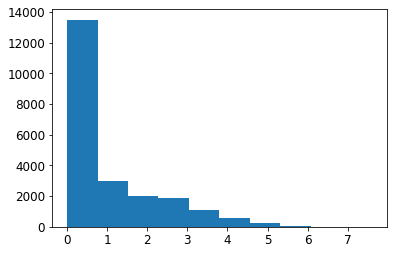

In [52]:
plt.hist(behaviour_pkl['fat_licks'])

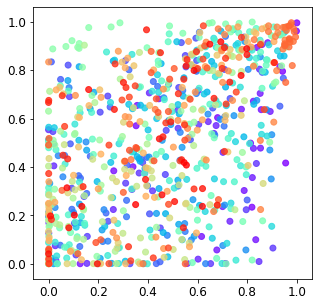

In [239]:
signals = signal_pkl['signals_transformed']
n1 = 1
n2 = 12
Y_all = np.array([signals[n1],signals[n2]]).T
name1, name2 = 'Background', 'Neuron 12'
#Y_all = np.array([behaviour_pkl['transformed_velocity'],signals[n1]]).T
X_all = np.array(behaviour_pkl['position'])#local_time
ve = np.array(behaviour_pkl['velocity'])

rule = (Y_all[:,0]>1e-4) & (Y_all[:,1]>1e-4)  \
        & (Y_all[:,0]<1.-1e-4) & (Y_all[:,1]<1.-1e-4) \
        & (behaviour_pkl['fat_licks'] > 2.4)
    
ve = ve[rule]
trials = behaviour_pkl['trials'][rule]
 
X = np.reshape(X_all[rule],(-1,1))
X[X<0] = 160.+X[X<0]
X[X>160] = X[X>160]-160.
X = X/160.
Y = Y_all[rule]

NSamp = X.shape[0]
plt.figure(figsize=(5,5))
colors = cm.rainbow(np.linspace(0., 1., NSamp))
skip = 3
plt.scatter(*Y[::skip].T, color=colors[::skip], alpha=0.8)

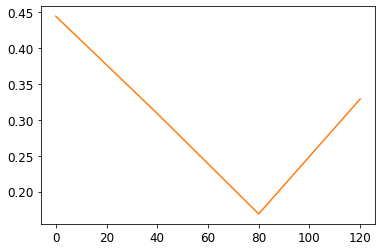

In [240]:
from scipy.stats import pearsonr
from scipy.stats import kendalltau

x,p,k = [],[],[]

X_pos = X.squeeze()*160
Y_pos = Y#norm.ppf(Y)

ds = 40.0

for b in range(int(160/ds)):
    dat = Y_pos[(X_pos>b*ds) & (X_pos<(b+1)*ds)]
    p.append(pearsonr(*dat.T)[0])
    k.append(kendalltau(*dat.T)[0])
    x.append((b+0)*ds)
    
p = np.convolve(np.array(p), np.ones((4,))/4, mode='valid')    
    
plt.plot(x[2:-1],p)
plt.plot(x,k)

x=x[2:-1]

In [241]:
trial_weights = np.zeros_like(trials)
for i, v in enumerate(trials):
    trial_weights[i] = (len(trials)/trials[-1])*1./np.count_nonzero(trials==v)

In [255]:
likelihoods = [#FrankCopula_Likelihood(),
                bvcopula.GaussianCopula_Likelihood(),
                bvcopula.ClaytonCopula_Likelihood(rotation='180°'),
                #bvcopula.IndependenceCopula_Likelihood(),
                #bvcopula.GumbelCopula_Likelihood(rotation='0°'),
                #GumbelCopula_Likelihood(rotation='0°'),
                ]

In [256]:
NSamp

2439

In [257]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=0)
train_y = torch.tensor(Y).float().cuda(device=0)
weights = torch.tensor(trial_weights).float().cuda(device=0)

In [260]:
# define the model (optionally on GPU)
grid_size = 128
thetas_sharing = torch.tensor([0,1])
if thetas_sharing is not None:
    num_fs = len(likelihoods)+thetas_sharing.max().numpy() # indep_thetas + num_copulas - 1
else:
    num_fs = 2*len(likelihoods)-1
print(num_fs)
model = bvcopula.Mixed_GPInferenceModel(bvcopula.MixtureCopula_Likelihood(likelihoods, theta_sharing=thetas_sharing), 
                               num_fs,  
                               prior_rbf_length=0.5, grid_size=grid_size, grid_bonds=torch.tensor([[0.,1.]])).cuda(device=0)

3


In [261]:
# train the model

torch.autograd.set_detect_anomaly(False)

base_lr = 0.01
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

#torch.autograd.set_detect_anomaly(True)

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.mean_module.parameters()},
    {'params': model.variational_strategy.variational_distribution.chol_variational_covar},
    {'params': model.variational_strategy.variational_distribution.variational_mean},
    #hyperparameters
    {'params': model.covar_module.raw_outputscale, 'lr': .001},
    {'params': model.covar_module.base_kernel.raw_lengthscale, 'lr': .001} #, 'lr': 0.001
], lr=base_lr)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = utils.VariationalELBO(model.likelihood, model, torch.tensor(trial_weights).float().cuda(), 
                            num_data=train_y.size(0), particles=torch.Size([0]), combine_terms=True)

losses, rbf, means = [], [], []

def train(train_x, train_y, mll, num_iter=2000):
    model.train()

    p = 0.
    nans = 0
    #mcmc = True
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
            
        #with gpytorch.settings.num_gauss_hermite_locs(50):
        loss = -mll(output, train_y) 
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss.detach().cpu().numpy())
        rbf.append(model.covar_module.base_kernel.lengthscale.detach().cpu().numpy())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy())
        if not (i + 1) % iter_print:
            
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}   length: {}, scale: {}, dLoss: {:.1}, NaNs: {}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().squeeze(), 
                model.covar_module.outputscale.detach().cpu().numpy().squeeze(),
                mean_p, nans
            ))
            if (0 < mean_p < 0.0001):
                print("Converged!")
                break
            p = 0.
            nans = 0
        
#             if mcmc & (0 < mean_p < 0.001):
#                 mcmc = False
#                 print('Swithing from MCMC to GH')
#                 mll = utils.VariationalELBO(model.likelihood, model, torch.tensor(trial_weights).float().cuda(), 
#                                 num_data=train_y.size(0), particles=torch.Size([0]), combine_terms=True)

        # The actual optimization step
        loss.backward()
        covar_grad = model.variational_strategy.variational_distribution.chol_variational_covar.grad
        # strict
        #assert torch.all(covar_grad==covar_grad)
        #light
        if torch.any(covar_grad!=covar_grad):
            for n, par in model.named_parameters():
                grad = par.grad.data
                #print(n)
                nans+=torch.nonzero(grad!=grad).shape[0]
                if torch.any(grad.abs()==float('inf')):
                    print("Grad inf... fixing...")
                    grad = torch.clamp(grad,-1.,1.)
                grad[grad!=grad] = 0.0
                par.grad.data = grad
        optimizer.step()
        
%time train(train_x,train_y,mll)

Basic lr for most of parameters: 0.01
Iter 100/2000 - Loss: -0.0987   length: [0.46857756 0.46230984 0.485649  ], scale: [0.7274882  0.7113868  0.68915534], dLoss: 0e+00, NaNs: 0
Iter 200/2000 - Loss: -0.115   length: [0.45700726 0.40753993 0.47468585], scale: [0.7141936  0.80788624 0.6586382 ], dLoss: 0.02, NaNs: 0
Iter 300/2000 - Loss: -0.119   length: [0.45793176 0.36652124 0.47020411], scale: [0.6730616 0.8762718 0.6151988], dLoss: 0.004, NaNs: 0
Iter 400/2000 - Loss: -0.121   length: [0.46143615 0.33557397 0.46415454], scale: [0.62880546 0.9168785  0.58670187], dLoss: 0.001, NaNs: 0
Iter 500/2000 - Loss: -0.122   length: [0.46496588 0.31179973 0.4482327 ], scale: [0.58639663 0.93090177 0.59342426], dLoss: 0.0007, NaNs: 0
Iter 600/2000 - Loss: -0.123   length: [0.46785092 0.29370755 0.42422304], scale: [0.5468468 0.9189272 0.6345916], dLoss: 0.0005, NaNs: 0
Iter 700/2000 - Loss: -0.123   length: [0.46952915 0.28000998 0.39751548], scale: [0.5108443  0.8836986  0.69681954], dLoss: 0

KeyboardInterrupt: 

In [262]:
# print(np.shape(means))
# for i in range(num_fs):
#     plt.plot(means[-1][i])
# losses[losses!=losses] = 0

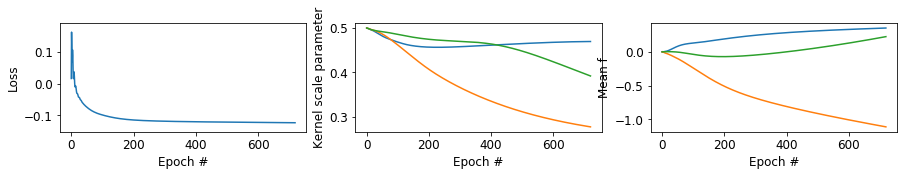

In [263]:
# prot loss function and kernel length
fig, (loss, kern, mean) = plt.subplots(1,3,figsize=(15,2))
loss.plot(losses)
loss.set_xlabel("Epoch #")
loss.set_ylabel("Loss")
marg = (np.max(losses) - np.min(losses))*0.1
loss.set_ylim(np.min(losses)-marg,
              np.max(losses)+marg)
rbf=np.array(rbf).squeeze()
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x,axis=1) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
fig.show()

In [264]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=0)

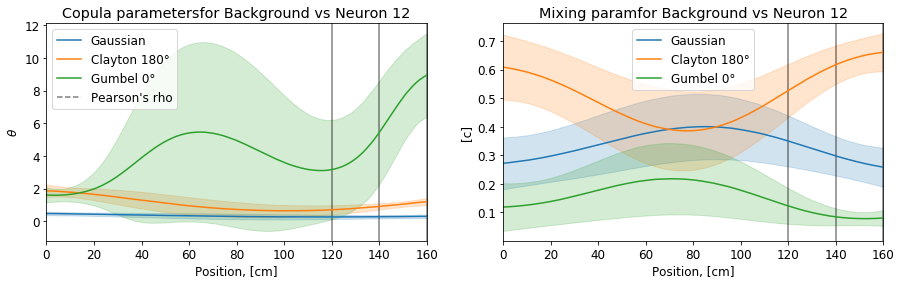

In [250]:
# visualize the result
fig, ax = plt.subplots(1,2,figsize=(15, 4))
    
for a in ax:
    a.axvline(120, color='black', alpha=0.5)
    a.axvline(140, color='black', alpha=0.5)
    a.axvline(160, color='black', alpha=0.5)    
    
utils.Plot_MixModel_Param_MCMC(ax,model,test_x,testX*160,rho=np.array([x,p]),title='for {} vs {}'.format(name1,name2))

plt.subplots_adjust(hspace=0.5)


In [251]:
loglik, params = model.likelihood.WAIC(model(train_x), train_y, combine_terms=False)
print(loglik, params, loglik-params)

tensor(411.5451, device='cuda:0') tensor(12.1446, device='cuda:0') tensor(399.4005, device='cuda:0')


In [254]:
n_int = 20
ints = np.linspace(0.,1.,n_int+1)
MIs = np.zeros((n_int,2))
#for i, (s,e) in enumerate(zip(ints[:-1],ints[1:])):
#     MIs[i] = [-el.cpu().numpy() for el in model.entropy(interv=torch.tensor([s,e]))]
MI, dMI = [-el.cpu().item() for el in model.entropy(sem_tol=1e-3)]

AssertionError: 

In [ ]:
mid = (ints[1:]+ints[:-1])/2
plt.plot(mid*160,MIs[:,0])
plt.fill_between(mid*160,MIs[:,0]-2*MIs[:,1],MIs[:,0]+2*MIs[:,1],alpha=0.3)
plt.plot(mid*160,np.ones_like(mid)*MI)
plt.fill_between(mid*160,np.ones_like(mid)*(MI-dMI),np.ones_like(mid)*(MI+dMI),alpha=0.3,label="MI={:.2}±{:.1}".format(MI,dMI))
plt.title('MI between {} and {}'.format(name1,name2))
plt.legend()

In [ ]:
# MIs_all = MIs
# MI_all = MI
# dMI_all = dMI

MIs_lick = MIs
MI_lick = MI
dMI_lick = dMI

# MIs_nolick = MIs
# MI_nolick = MI
# dMI_nolick = dMI

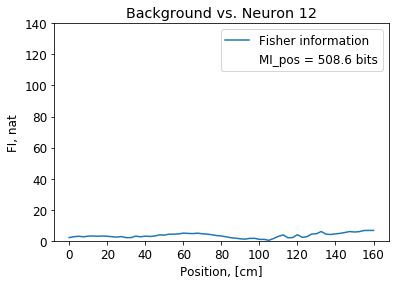

In [87]:
plt.rcParams.update({'font.size': 12})

ds = 2.5
n = int(160/ds)

FI, MI = model.likelihood.input_information(model,train_y,n,160.)

plt.plot(np.arange(n+1)*ds,FI.detach().cpu().numpy(),label='Fisher information')
plt.plot(0,0,color='white',label='MI_pos = {:.1f} bits'.format(MI.detach().cpu().numpy()/np.log(2)))
plt.title("{} vs. {}".format(name1,name2))
plt.xlabel('Position, [cm]')
plt.ylabel('FI, nat')
plt.ylim(0,140)
plt.legend()

In [35]:
#generate some samples
model.eval()
with gpytorch.settings.num_likelihood_samples(1):
    gplink = model.likelihood.gplink_function
    copulas = [lik.copula for lik in likelihoods]
    rotations = [lik.rotation for lik in likelihoods]
    thetas, mixes = gplink(model(test_x).mean)
    test_y = model.likelihood.copula(thetas,mixes,copulas,rotations=rotations,theta_sharing=thetas_sharing).rsample()
    Y_sim = test_y.cpu().detach().numpy()

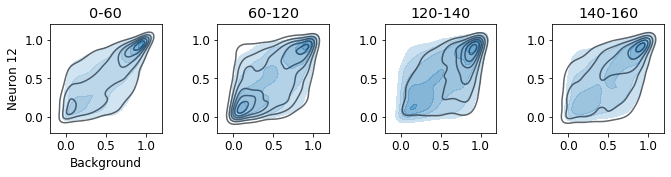

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(11,2))
fig.subplots_adjust(hspace=0.5)

axes[0].set_ylabel(name2)
axes[0].set_xlabel(name1)

interval_ends = [0,60,120,140,160]
utils.Plot_Copula_Density(axes, testX.squeeze()*160, Y_sim.squeeze(), interval_ends, shade=True)
utils.Plot_Copula_Density(axes, X.squeeze()*160, Y, interval_ends, shade=False, color='#073763ff')

plt.subplots_adjust(wspace=0.5)

In [174]:
l = behaviour_pkl['fat_licks'][rule]
p_lick = len(l[l>.5])/len(l)
p_lick

0.4290849856765714

In [175]:
MI_lick * p_lick + MI_nolick * (1-p_lick) - MI_all

-0.004228165994994648

In [176]:
MIsd = MIs_lick * p_lick + MIs_nolick * (1.-p_lick) - MIs_all
MIsd[:,1] = MIs_lick[:,1] * p_lick + MIs_nolick[:,1] * (1-p_lick) + MIs_all[:,1]

In [177]:
MIs_lick.shape

(20, 2)

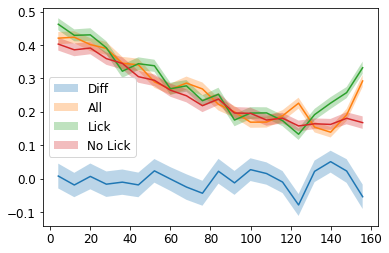

In [178]:
mid = (ints[1:]+ints[:-1])/2*160
def plot_MIs(MIs,label):
    plt.plot(mid,MIs[:,0])
    plt.fill_between(mid,MIs[:,0]-2*MIs[:,1],MIs[:,0]+2*MIs[:,1],alpha=0.3,label=label)
plot_MIs(MIsd,'Diff')
plot_MIs(MIs_all,'All')
plot_MIs(MIs_lick,'Lick')
plot_MIs(MIs_nolick,'No Lick')
plt.legend()
# plt.plot(mid,np.ones_like(mid)*MI)
# plt.fill_between(mid,np.ones_like(mid)*(MI-dMI),np.ones_like(mid)*(MI+dMI),alpha=0.3,label="MI={:.2}±{:.1}".format(MI,dMI))
#plt.legend()

In [ ]:
MI_all